# 5.0 Model Inference
## Using our ADMET model to predict on new data
Now that we've compared our models and done some analysis, we've determined the best model to use for our use-case, the ensemble LGBM model. We now want to use this best performing model to predict the activity of a set of new compounds against CYP3A4.

### Requirements
For this demo, you will need:
1. A model trained in anvil
2. A dataset of compounds unseen by the model. The dataset must contain a column of SMILES strings.

## [OPTIONAL] Data Cleaning
You may want to do some data cleaning prior to model prediction, i.e. standardizing the SMILES strings and dropping any duplicates. We have done that already with `processed_data/cleaned_new_compounds.csv`.

## Use Anvil to predict on the new set of compounds
As with training models with Anvil, doing model inference is also a simple command with the following arguments:
```bash
    openadmet predict \
        --input-path <the path to the data to predict on> \
        --input-col <the column to of the data to predict on, often SMILES> \
        --model-dir <the anvil_training directory of the model to predict with> \
        --output-csv <the path to an output CSV to save the predictions to> \
        --accelerator <whether to use gpu or cpu, defaults to gpu>
```

In [ ]:
%%bash
export OADMET_NO_RICH_LOGGING=1

openadmet predict \
    --input-path processed_data/cleaned_new_compounds.csv \
    --input-col OPENADMET_CANONICAL_SMILES \
    --model-dir ../04_Ensemble_Model_training/ensemble \
    --output-csv predictions.csv \
    --accelerator cpu

## Analyze your predictions
With the newly created `predictions.csv` file, you can now perform any data analysis you like to find which compounds are worth further exploring, i.e. empirically.

Text(0.5, 1.0, 'Distribution of predicted pIC50s')

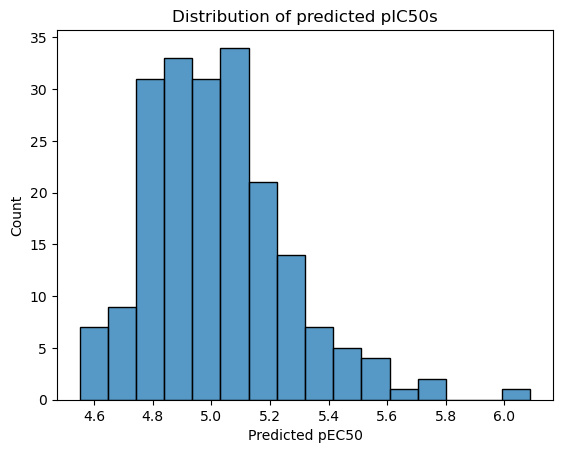

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("predictions.csv")

plt.figure()
sns.histplot(data=df, x='OADMET_PRED_openadmet-chembl_OPENADMET_LOGAC50')
plt.xlabel("Predicted pEC50")
plt.title("Distribution of predicted pIC50s")

Because we are using an ensemble model for predictions, we can also visualize the uncertainty of our predictions by adding error bars.

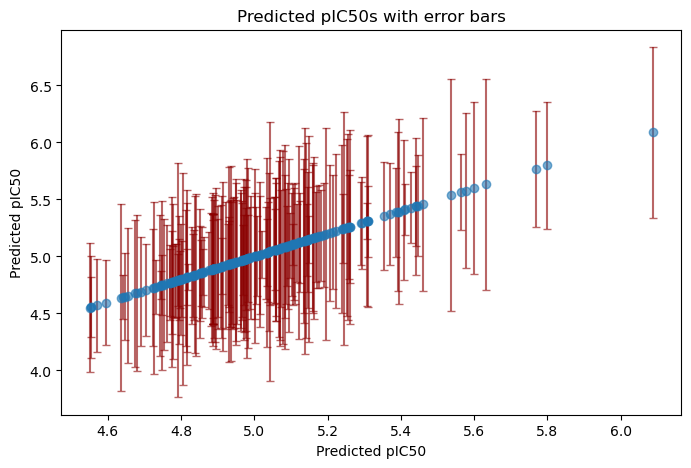

In [3]:
plt.figure(figsize=(8,5))
plt.errorbar(
    x=df['OADMET_PRED_openadmet-chembl_OPENADMET_LOGAC50'],
    y=df['OADMET_PRED_openadmet-chembl_OPENADMET_LOGAC50'],
    yerr=df['OADMET_STD_openadmet-chembl_OPENADMET_LOGAC50'],
    fmt='o',
    ecolor='darkred',
    alpha=0.6,
    capsize=3
)
plt.xlabel("Predicted pIC50")
plt.ylabel("Predicted pIC50")
plt.title("Predicted pIC50s with error bars")
plt.show()

~ End of `05_Model_Ensemble_Inference` ~